# Exploratory Data Analysis (EDA) of the Lynx-ID dataset

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset.csv")
df

,filepath,lynx_id,source,pattern,date,location,image_number
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,5
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,1
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,6
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,7
...,...,...,...,...,...,...,...
3325,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4
3326,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3
3327,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,1
3328,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,2


### NaN values

In [45]:
percentages_na = df.loc[:, df.columns != "filepath"].apply(lambda col: col.isna().mean() * 100)
percentages_na

lynx_id         0.000000
source          0.030030
pattern         3.963964
date            0.870871
location        6.546547
image_number    0.000000
dtype: float64

### Number of images per pattern

In [3]:
df["pattern"].value_counts()

OCELLES    2393
SPOTS       803
OCS           1
OFB           1
Name: pattern, dtype: int64

### Number of individuals

In [4]:
nb_images_per_individuals = df["lynx_id"].value_counts()

print(f"{len(nb_images_per_individuals)} unique individuals")
nb_images_per_individuals

274 unique individuals


F39-060         250
F39-054          90
163              82
F25-008          74
F39-095=1556     69
               ... 
1717              2
1044=L261         2
1017              2
1556              1
Villard           1
Name: lynx_id, Length: 274, dtype: int64

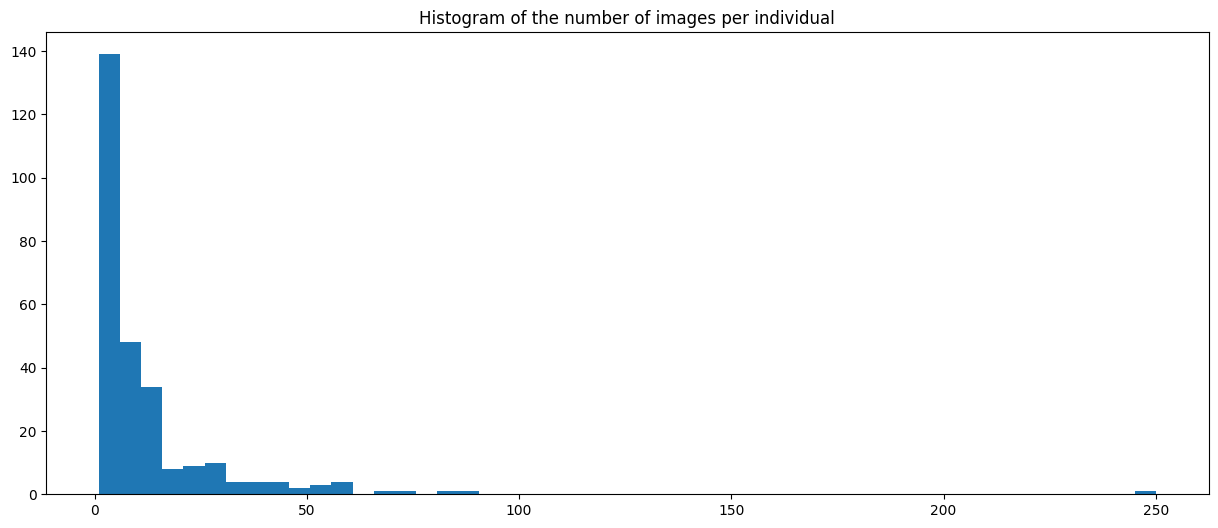

In [65]:
plt.figure(figsize=(15, 6))
plt.hist(nb_images_per_individuals, bins=50)
plt.title("Histogram of the number of images per individual")
plt.show()

In [5]:
print(f"On average, there are {np.mean(nb_images_per_individuals)} images per individual")

On average, there are 12.153284671532846 images per individual


In [6]:
print(f"{len(nb_images_per_individuals[nb_images_per_individuals < 3])} individuals have less than 3 images")

66 individuals have less than 3 images


### Location

In [7]:
df["location"].value_counts()

Syam                        105
Contrevoz                    90
Les-Planches-En-Montagne     88
Les-Combes                   82
Orchamps-Vennes              70
                           ... 
02-15                         1
Cret-Sapeau                   1
Poizat-Riffard                1
Jussy                         1
2021-05-13-NA                 1
Name: location, Length: 374, dtype: int64

### Image dimensions

In [8]:
from data_pipeline.dataset import LynxDataset
from pathlib import Path

In [9]:
lynxDataset = LynxDataset(Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset.csv"))

In [10]:
lynxDataset.__len__()

3330

(1984, 2576, 3)


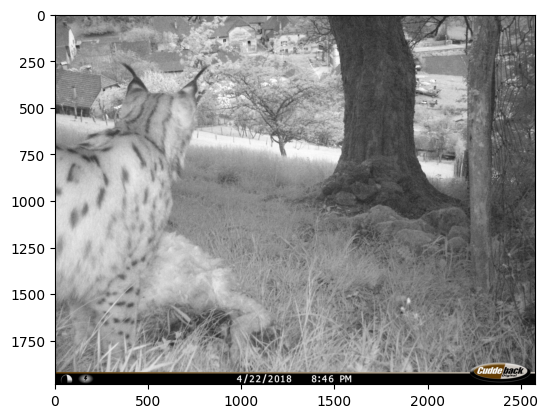

In [11]:
import matplotlib.pyplot as plt

image = lynxDataset.__getitem__(3000)[0]
plt.imshow(image)
print(image.shape)

In [12]:
heights = []
widths = []

for i, image_i in enumerate(lynxDataset):
    try:
        heights.append(image_i[0].shape[0])
        widths.append(image_i[0].shape[1])
    except:
        print(i, df.iloc[i]['filepath'])
        continue

Corrupt JPEG data: premature end of data segment


502 /gpfsscratch/rech/ads/commun/datasets/extracted/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_1376/1376_OFB_OCELLES_2020-06-15_NA_23.png


libpng error: Read Error


2032 /gpfsscratch/rech/ads/commun/datasets/extracted/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OFB_ocelles/OFB_OCELLES_F25-067=1376/F25-067=1376_OFB_OCELLES_2020-06-15_Orchamps-Vennes_29.png


libpng error: Read Error
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 64120 extraneous bytes before marker 0xd5
Corrupt JPEG data: 3406 extraneous bytes before marker 0xd9


In [13]:
average_width = sum(widths)/len(widths)
average_height = sum(heights)/len(heights)

print('Average width: {} and height: {}'.format(average_width, average_height))

Average width: 2284.947716346154 and height: 1642.9456129807693


#### Width and height distribution

Text(0.5, 1.0, 'Image height')

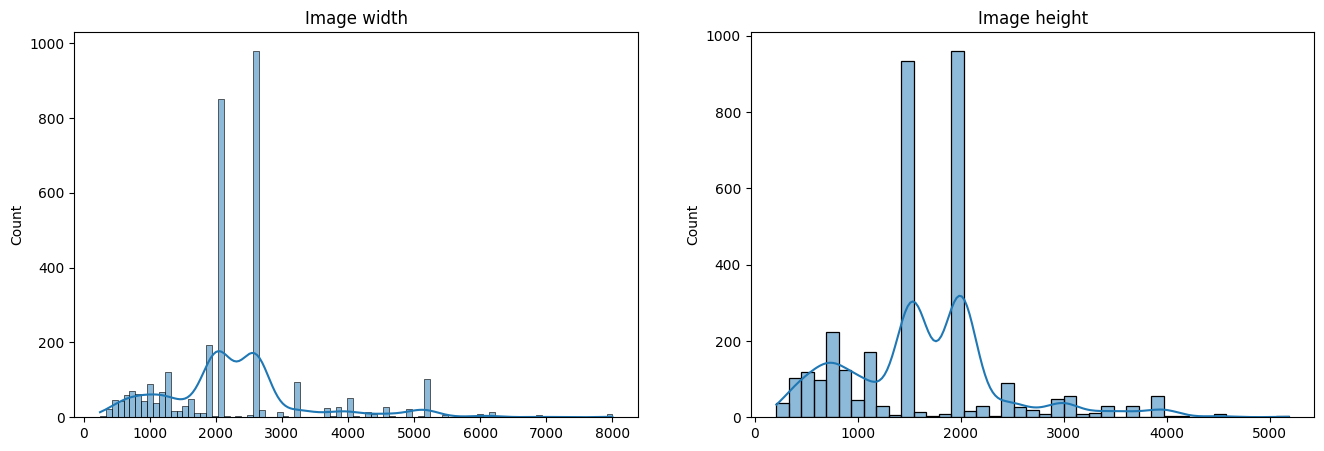

In [14]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(widths, kde=True, ax=axes[0])
axes[0].set_title("Image width")
sns.histplot(heights, kde=True, ax=axes[1])
axes[1].set_title("Image height")

In [15]:
print(f"Lowest height : {min(heights)}")
print(f"Highest height : {max(heights)}")

print(f"Lowest width : {min(widths)}")
print(f"Highest widths : {max(widths)}")

Lowest height : 208
Highest height : 5184
Lowest width : 249
Highest widths : 8000


In [18]:
ratios = []
for height, width in zip(heights, widths):
    ratios.append(width/height)
        
print(f"Mean ratio: {np.mean(ratios)}")

Mean ratio: 1.4099835570583974


#### Ratio distribution

Text(0.5, 1.0, 'Ratio distribution')

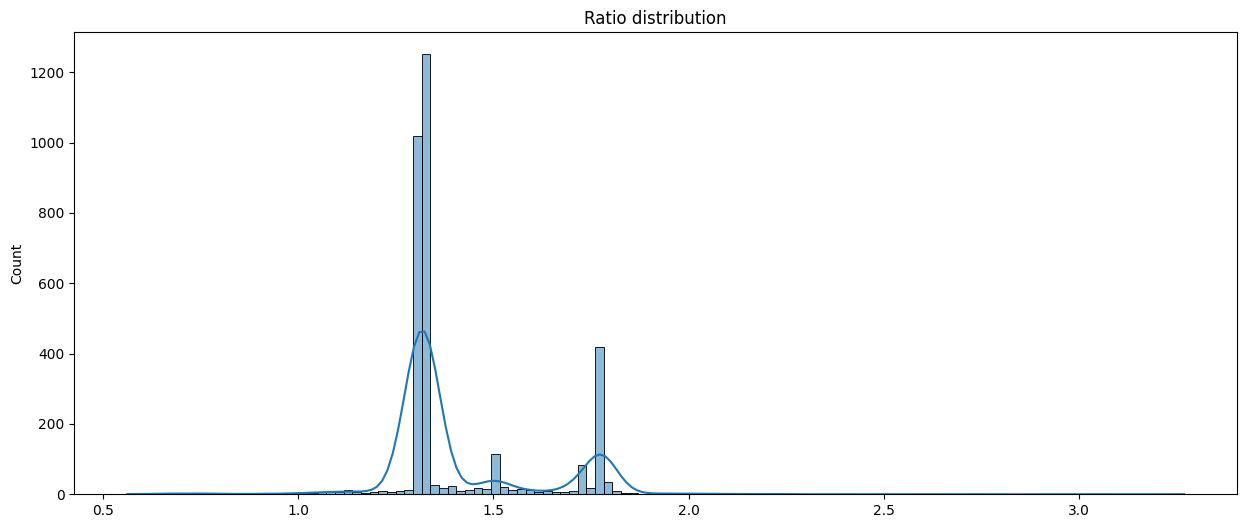

In [25]:
plt.figure(figsize=(15, 6))
sns.histplot(ratios, kde=True)
plt.title("Ratio distribution")